In [1]:
import sys, os
# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import trim_correlation_trace
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import obspy
import pandas as pd
import seaborn as sns
sns.set_context("paper")
#%config InlineBackend.figure_format ='retina'
ext = os.path.join(module_path, "jupyter-tutorials")

/home/hoogewg/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoogewg/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoogewg/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(


<h1><center>Clock error correction of seismic sensors</center></h1>
<h2>Introduction</h2>

Accurate timing of seismic records is essential for almost all applications in seismology. Wrong timing of the waveforms may result in incorrect Earth models and/or inaccurate earthquake locations. As such, it may render false interpretations of underground processes.

To avoid this issue, internal clocks of seismic land stations are frequently synchronized with a GNSS signal with the correct reference time (Hable et al., 2018). In some cases the synchronization can fail (e.g., due to weather conditions), which adds a time shift relative to the reference time (e.g., Sens-Schonfelder, 2008).

Furthermore, Ocean bottom seismometers **(OBSs)** experience a *clock drift effect* due to their inability to synchronize with a GNSS signal (with the correct reference time). 

One way to find out if there is a clock error is to compare the time before OBS deployment with it's recovery time. If there is a difference between both times it means that the internal clock of the seismometer was drifting from the reference time. This value is known as the **skew value**.

### OBS clock errors of the IMAGE project

Seismic activity was recorded on the Reykjanes peninsula (SW Iceland) between spring 2014 until August 2015. The stations were deployed in the context of IMAGE (Integrated Methods for Advanced Geothermal Exploration) and consisted of 30 on-land stations and 24 ocean bottom seismometers (OBSs) (Blanck et al., 2020; Jousset et al., 2020; Weemstra et al., 2021). From the 24 OBSs, 20 showed a deviation between the internal clock and the reference time. The internal clock of the remaining 4 OBS was not working when the stations were recovered. the following table and figure show the location of the stations and the metadata of each sensor. 

In [2]:
station_file = "station_info"
df = pd.read_csv(station_file, delim_whitespace=True)
df.head(4)

,PROJECT,SENSORCODE,needs_correction(True/False),LATITUDE,LONGITUDE,ELEVATION(m),SENSORTYPE
0,IMAGE,O01,True,63.78344,-22.01142,-106.0,PZ_OBS
1,IMAGE,O02,True,63.78321,-22.22867,-100.0,PZ_OBS
2,IMAGE,O03,True,63.77156,-22.47474,-111.0,PZ_OBS
3,IMAGE,O04,True,63.75381,-22.70060,-137.0,PZ_OBS


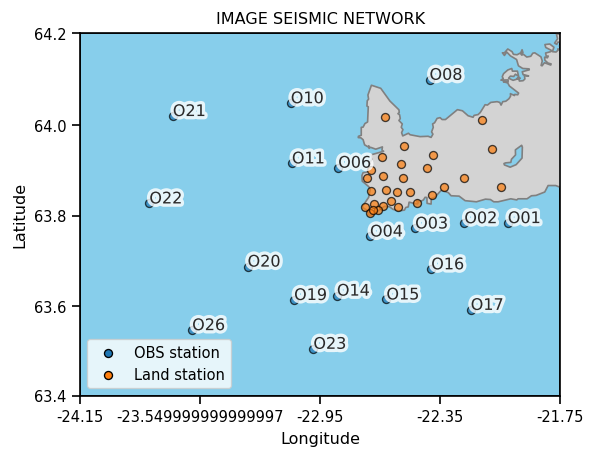

In [3]:
latitudes, longitudes = df["LATITUDE"], df["LONGITUDE"]
station_codes = df["SENSORCODE"]
needs_correction = df["needs_correction(True/False)"]


# Number of ticks in y and x-axes.
n_ticks = 5

# Create the figure using Basemap.
fig, ax = plt.subplots(1,1, dpi=120)
llcrnrlon = -24.15
urcrnrlon = -21.75
llcrnrlat = 63.4
urcrnrlat = 64.2
map = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
              urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
              epsg=3857, resolution='h')

for sta_code, sta_lat, sta_lon, correction in zip(station_codes, 
                                                  latitudes, 
                                                  longitudes, 
                                                  needs_correction):
    if correction:
        ax.annotate(sta_code, map(sta_lon, sta_lat), zorder=9999, alpha=0.8,
                    path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    x, y = map(sta_lon, sta_lat)
    # Add a color depending wether the staton needs corection or not
    # In these data-set file the column "needs correction" is True for OBS, so 
    # we use this attribute to select the color.
    color = 'C0' if correction else 'C1'
    map.scatter(x, y, c=color, zorder=999,
                edgecolor='k', alpha=0.7)

# We add the legend.
map.scatter([],[], label='OBS station', color='C0', edgecolor='k')
map.scatter([],[], label='Land station', color='C1', edgecolor='k')
plt.legend(loc=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IMAGE SEISMIC NETWORK')

# Add the labels
x, y = map(np.linspace(llcrnrlon, urcrnrlon, n_ticks),
           np.linspace(llcrnrlat, urcrnrlat, n_ticks)
           )
plt.xticks(x, np.linspace(llcrnrlon, urcrnrlon, n_ticks))
plt.yticks(y, np.linspace(llcrnrlat, urcrnrlat, n_ticks))
map.drawmapboundary(fill_color='skyblue')
map.fillcontinents(color='lightgray')
map.drawcoastlines(color='grey')
plt.show()

### Skew values

The **OBSs** of the IMAGE project were synchronized with a GPS signal before and after recovery (a common protocol). After calculating the differences between the GPS reference time and the internal clock time (**skew values**) we found out that all the sensors had a time deviation. The following table shows the different skew values in microseconds for the differen OBSs. The following figure shows the plot of the skew values of each station in seconds. Station O20 had a skew value of almost 5 seconds.

In [4]:
os.chdir ('/home/hoogewg/Documents/GitHub/ocloc/src/ocloc')
skew_values_file = "skew_values.csv"
skew_df = pd.read_csv(skew_values_file, delimiter=",", header=0)
display(skew_df)

,Sensor code,Latitude,Longitude,Elevation,Sensor type,Start time,End time,Skew microseconds,skew seconds
0,O01,63.78344,-22.01142,-106.0,PZ_OBS,2014-08-22T19:12:56,2015-08-26T21:47:41,2023125.0,2.023125
1,O02,63.78321,-22.22867,-100.0,PZ_OBS,2014-08-22T19:03:35,2015-07-20T05:06:14,1790906.0,1.790906
2,O03,63.77156,-22.47474,-111.0,PZ_OBS,2014-08-22T20:23:08,2015-08-26T21:20:00,1137506.0,1.137506
3,O04,63.75381,-22.70060,-137.0,PZ_OBS,2014-08-22T19:53:43,2015-08-26T21:29:16,1774437.0,1.774437
4,O05,63.77284,-22.84096,-79.0,PZ_OBS,2014-08-20T22:43:11,NaN,NaN,NaN
5,O06,63.90564,-22.85941,-91.0,PZ_OBS,2014-08-21T19:53:29,2015-08-30T11:07:25,1129468.0,1.129468
6,O07,63.97613,-22.88025,-81.0,PZ_OBS,2014-08-19T11:13:02,2015-08-30T09:06:42,1758837.0,1.758837
7,O08,64.09820,-22.40290,-36.0,PZ_OBS,2014-08-10T12:26:05,2015-08-29T22:21:11,1099625.0,1.099625
8,O10,64.04705,-23.09651,-99.5,PZ_OBS,2014-08-20T17:18:42,2015-08-31T14:20:05,1813093.0,1.813093
9,O11,63.91500,-23.09100,-119.0,PZ_OBS,2014-08-20T18:40:48,2015-08-30T10:15:08,1469656.0,1.469656


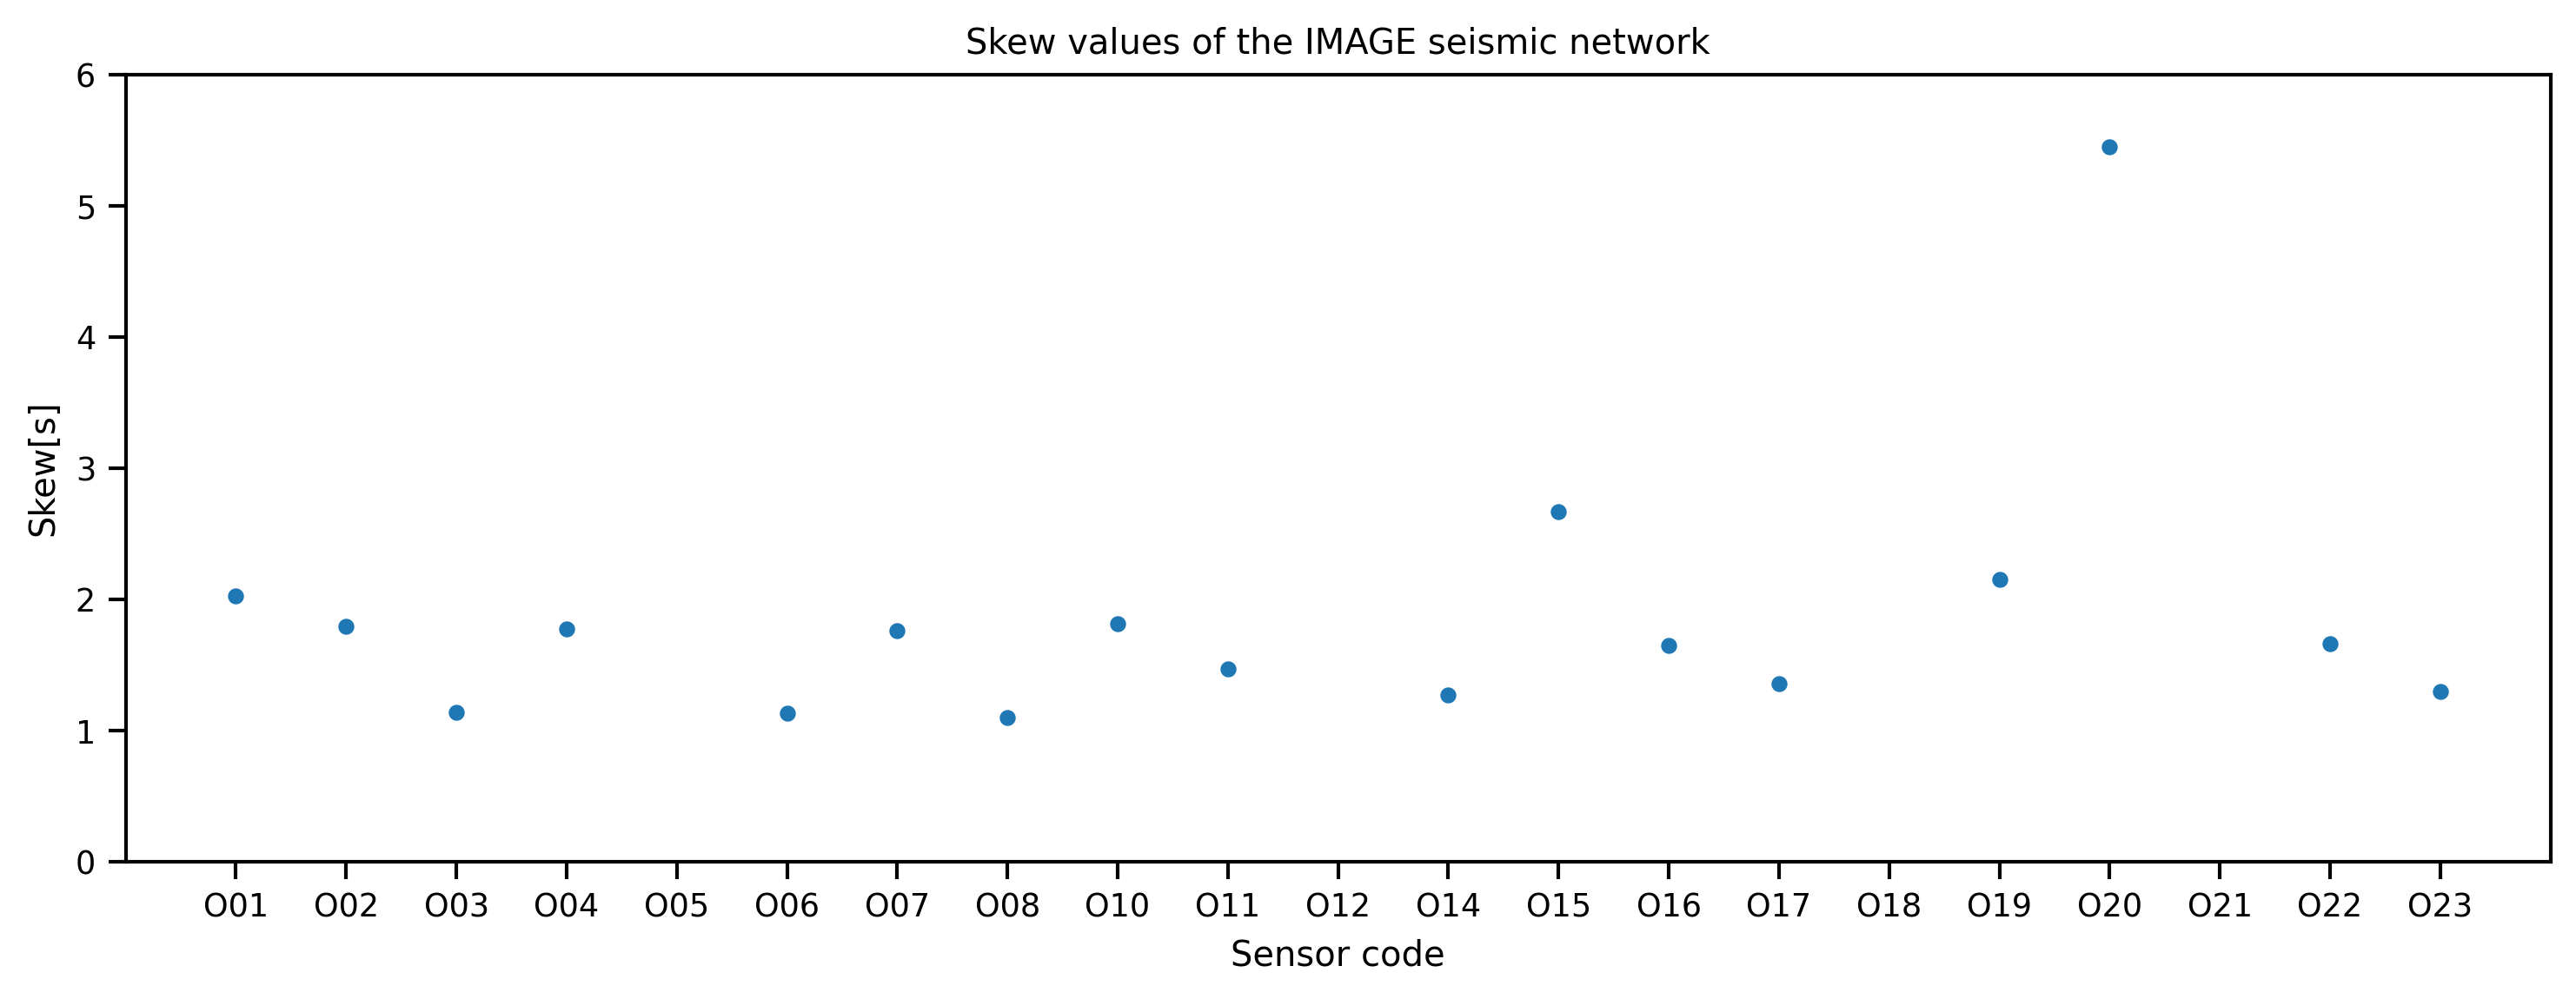

In [5]:
plt.figure(figsize=(12,4), dpi=300)
skew_df["Skew[s]"] = skew_df["Skew microseconds"]/(10**6)
b = sns.scatterplot(data=skew_df, y="Skew[s]", x="Sensor code")
plt.ylim(0, 6)
plt.title("Skew values of the IMAGE seismic network")
plt.show()

#### Using skew values for correcting timing errors
As OBSs generally operate in relatively stable ambient temperatures, the timing deviation is usually assumed to be linear. In the following cells we show the correction applied using the skew values.

In [6]:
station_code = "O20"

,Sensor code,Latitude,Longitude,Elevation,Sensor type,Start time,End time,Skew microseconds,skew seconds,Skew[s]
17,O20,63.68719,-23.31253,-109.0,PZ_OBS,2014-08-20T17:51:50,2015-08-30T23:39:12,5445781.0,5.445781,5.445781


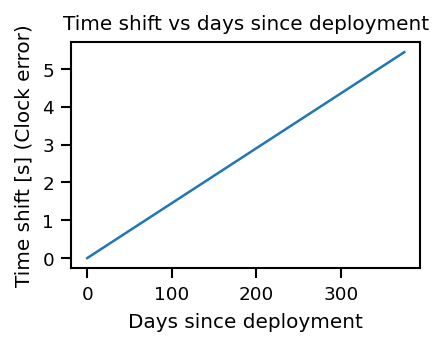

In [7]:
# Select the row of the dataframe containing the station info
station_info = skew_df.loc[skew_df['Sensor code'] == station_code]

# Retrieve the values for the correction.
start_time = obspy.UTCDateTime(station_info["Start time"].iloc[0])
end_time = obspy.UTCDateTime(station_info["End time"].iloc[0])

skew_value = station_info["Skew[s]"].iloc[0]
time_shift_rate = skew_value/(end_time-start_time)

seconds_since_deployment = (end_time-start_time)

display(station_info)

# Time vector with only two points.
t = np.linspace(0, int(seconds_since_deployment), 2)

# Corrected time after skew correction.
correct_time = t*time_shift_rate

# Convert to days for plot purposes.
plt.figure(figsize=(3, 2), dpi=150)
plt.plot(t/86400, correct_time)
plt.xlabel("Days since deployment")
plt.ylabel("Time shift [s] (Clock error)")
plt.title("Time shift vs days since deployment")
plt.show()

#### Issues with skew values
If the instrument has **run out of power before recovery** (i.e., dead battery), the timing error at the end of the deployment cannot be determined. 

In the image network we recovered 4 seismic sensors with a dead battery, therefore, it was not possible to calculate the skew values. The sensors were

1. O05
2. O11
3. O18
4. O21

After all the efforts spent in the deployment and recovery of these instruments we would like to get an accurate timing of the waveforms. Moreover, the drift may not be linear, e.g., due to rapid temperature drop while the OBS sinks to the seabed. It is therefore necessary to combine skew measurements with other methods that use the data directly instead.

# Seismic interferometry

The principle of Seismic interferometry (SI) can be used for the detection and correction of clock errors in seismic data. SI implies generating new seismic responses by computing the time cross-correlation function of wavefields recorded at each station, which are excited by randomly distributed sources (Wapenaar & Fokkema, 2006; Stehly et al., 2006). These new seismic responses contain, at least partly, the Green's function between the receivers (Wapenaar, 2010; Stehly et al., 2006). These responses should be symmetric for homogeneously distributed noise sources. 

The sources of ambient seismic noise are likely to be close to the Earth's surface as they are mostly made of surfacewaves (Stehly et al., 2006; Halliday & Curtis, 2008; Kimman & Trampert, 2010). The mechanisms generating seismic noise are attributed to pressure perturbations in the atmosphere, ocean or Earth's surface, namely ocean waves, tides, strong wind,  human activity, and industry (Bonnefoy-Claudet et al., 2006; Stehly et al., 2006). Furtheremore, the mechanisms of seismic noise differ for different frequency bands. At short periods (<20 s), the two strongst peaks of the seismic noise are related to the interaction of sea waves with the coast (Gutenberg, 1951). These two peaks are reffered to as primary and secondary microseisms (Stehly et al., 2006).

<img src="figures/Cantner_Microseisms.jpg" style="width: 300px;" caption="Drawing">

**Figure taken from** https://www.earthmagazine.org/article/sounding-out-earths-hum/



[Include sentence explaining that the shape of the cross correlations can be used to find timing errors]. 


The cross-correlation of seismic wavefields with perfectly random distribution of seismic noise sources results in symmetric cross correlations with seismic responses at positive (causal part) and negative (acausal part) correlation lag times (Yang et al., 2008). The causal part of the cross correlation represents the response (or Green's function) of station 2 to a delta pulse at location of station 1, and the the acausal part is the response at station 1 from a delta pulse at the location of station 2 (Hable et al., 2017). In the ideal case, with perfectly random distribution of noise sources, there is energy that accumulates with the shape of a virtual surface wave at both, causal and acausal part. These two virtual responses are symmetrical around the zero axes if the noise sources are evenly distributed and there are no clock errors. Based on the symmetry between the two virtual responses, it is possible to detect errors in the internal clocks of the seismometers.

The shapes of the causal and acausal virtual response may differ if the noise sources are not evenly distributed (Stehly et al., 2006). A non-uniform illumination pattern may also affect the symmetry of the virtual responses which might affect the methodology we proposed. In section 4: Inversion strategies, we will focus on how to overcome this issue.

<img src="figures/Stehly2006.png" style="width: 700px;" caption="Drawing">

The following figure shows the time-lapse time-averaged cross-correlation function between receivers HAH and O20. It can be seen the causal and acausal parts, as well as the difference in amplitudes between both virtual responses. The amplitudes of both surface waves differ due to a nonisotropic distribution of noise sources, given that the OBS is affected by ocean waves, whereas station HAH is a land station with less noise sources.

In [11]:
from main import read_xcorrelations, read_correlation_file
station1_code= "HAH"
station2_code = "O20"

path2data_dir = os.path.join(ext, "correlations_O20/")
correlations, _ = read_xcorrelations(station1_code, station2_code, path2data_dir)
tr = read_correlation_file(path2data_dir + "HAH_O20_1413546632_100.sac")

min_t=-40
max_t=40
freqmin=0.15
freqmax=0.3

# Trim the signal to use only the part we are interested at.
t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)

# index of matching element
acausal_indixes = [idx for idx, val in enumerate(t1) if val > -22 and val < -10]
causal_indixes = [idx for idx, val in enumerate(t1) if val > 12 and val < 25]

#fig, (ax1) = plt.subplots(1, 1, figsize=(5,3), dpi=300)
fig =plt.figure(dpi=300)
ax1 = fig.add_subplot(122)
ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])
ax1.plot(t1[acausal_indixes], data[acausal_indixes], 
         label="Acausal wave", marker="+", color="C3")
ax1.plot(t1[causal_indixes], data[causal_indixes], 
         label="Causal wave", marker=".", color="C3")

ax1.set_title(tr.stats.station_pair)
ax1.set_ylabel('Amplitudes')
ax1.legend(loc=2)
plt.tight_layout()
#plt.show()

#############################################################
station1df = df.loc[df['SENSORCODE'] == station1_code]
station2df = df.loc[df['SENSORCODE'] == station2_code]

merged_dfs = pd.concat([station1df, station2df])


latitudes, longitudes = merged_dfs["LATITUDE"], merged_dfs["LONGITUDE"]
station_codes = merged_dfs["SENSORCODE"]
needs_correction = merged_dfs["needs_correction(True/False)"]

# Create the figure using Basemap.
#fig, ax = plt.subplots(1, 1, dpi=120)
ax = fig.add_subplot(121)
map = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
              urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
              epsg=3857, resolution='h')

for sta_code, sta_lat, sta_lon, correction in zip(station_codes, 
                                                  latitudes, 
                                                  longitudes, 
                                                  needs_correction):
    ax.annotate(sta_code, map(sta_lon, sta_lat), zorder=9999, alpha=0.8,
                path_effects=[pe.withStroke(linewidth=4, foreground="white")])
    x, y = map(sta_lon, sta_lat)
    # Add a color depending wether the staton needs corection or not
    # In these data-set file the column "needs correction" is True for OBS, so 
    # we use this attribute to select the color.
    color = 'C0' if correction else 'C1'
    map.scatter(x, y, c=color, zorder=999,
                edgecolor='k', alpha=0.7)

# We add the legend.
map.scatter([],[], label='OBS station', color='C0', edgecolor='k')
map.scatter([],[], label='Land station', color='C1', edgecolor='k')
plt.legend(loc=3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IMAGE SEISMIC NETWORK')

# Add the labels
x, y = map(np.linspace(llcrnrlon, urcrnrlon, n_ticks),
           np.linspace(llcrnrlat, urcrnrlat, n_ticks)
           )
plt.xticks(x, np.linspace(llcrnrlon, urcrnrlon, n_ticks))
plt.yticks(y, np.linspace(llcrnrlat, urcrnrlat, n_ticks))
map.drawmapboundary(fill_color='skyblue')
map.fillcontinents(color='lightgray')
map.drawcoastlines(color='grey')
plt.show()

SyntaxError: invalid syntax (2980184530.py, line 1)

#### Evidence of timing errors in time-lapse time-averaged cross-correlations

In [9]:
path2data_dir = os.path.join(ext, "correlations_O20/")
correlations, _ = read_xcorrelations(station1_code, station2_code, path2data_dir)

correlations = correlations.normalize()
min_t=-30
max_t=0
freqmin=0.15
freqmax=0.3

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2), dpi=200)
for tr in correlations:
    # Trim the signal to use only the part we are interested at.
    t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)

    # index of matching element
    acausal_indixes = [idx for idx, val in enumerate(t1) if val > -22 and val < -10]
    causal_indixes = [idx for idx, val in enumerate(t1) if val > 12 and val < 25]
    ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])


# Adding an arrow to graph starting 
# from the base (2, 4) and with the 
# length of 2 units from both x and y
# And setting the width of arrow for
# better visualization
plt.arrow(-18, 0.8, 4, 0, width = 0.1)

ax1.set_title(tr.stats.station_pair)
ax1.set_ylabel('Amplitudes')
ax1.legend(loc=2)
plt.tight_layout()

NameError: name 'read_xcorrelations' is not defined

Two approaches stand out when using interferometry for the recovery of timing errors (Goudard et al., 2014). The first approach relies on the temporal stability of time-averaged cross-correlations. [Explain the two approaches.... use the following fragment of Weemstra].


""When it comes to the interferometric recovery of timing errors, two approaches can be distinguished (Goue ́dard et al. 2014). The first approach relies on the (presumed) temporal stability of time-averaged cross-correlations. In this approach, virtual-source responses are retrieved in a time-lapse manner to recover temporal variations in timing errors (e.g. clock drift; Hable et al. 2018). Specifically, in application to ambient seismic surface-wave noise, time-lapse changes in the arrival times of the direct interferometric surface-waves are used for this purpose. This approach generally recovers timing errors using time-averaged cross-correlations computed between single pairs of stations. As such, one of the two stations needs to be devoid of timing errors, whereas the recordings by the other station can be subject to timing/clock errors. The latter station, however, is required to have zero timing error at a specific reference time. For this approach, it suffices if only a virtual-source response at positive time, or a virtual-source response at negative time is retrieved (in a time-lapse manner). 
The second approach exploits the (theoretical) pairwise time symmetry of the time-averaged cross-correlations to recover timing errors (e.g. Stehly et al. 2007; Sens-Scho ̈nfelder 2008; Hatchell & Mehta 2010). Contrary to the first approach, both a direct surface-wave arrival at positive time and a direct surface-wave arrival at negative time need to be retrieved in this case. Similar to the first approach, however, one of the two stations needs to be devoid of timing errors. Importantly, and contrary to the first approach, the recordings by the other station need not be subject to a zero timing error at a specific reference time. Since our data set contains stations whose recordings are subject to a fixed timing error (i.e. not zero at a specific reference time), we adopt and investigate the second approach in this study."" Weemstra, 2021.

In [ ]:
station1df = df.loc[df['SENSORCODE'] == station1_code]
station2df = df.loc[df['SENSORCODE'] == station2_code]

merged_dfs = pd.concat([station1df, station2df])

### Using seismic interferometry to detect clock errors

If there is an instrumental timing error the cross-correlation response is shifted making the causal part closer to t=0 and the acausal part further away from the zero, or viceversa. 



In nature, noise sources are often distributed unevenly, which leads to asymmetric CCFs (Stehly et al. 2007). Temporal CCF changes can be caused by several mechanisms, which are sum- marized by Stehly et al. (2007). Velocity changes in the subsurface would affect a CCF’s causal and acausal parts in analogous ways, by dilating or compressing the CCF’s waveforms on either side of t = 0, corresponding to slower or faster wave propagation, respectively. Such changes in wave propagation are expected in the vicinity of faults after large earthquakes (e.g. Brenguier et al. 2008b) or close to volcanoes, reflecting magma movements (e.g. Brenguier et al. 2008a; Sens-Scho ̈nfelder et al. 2014). However, there are no large earthquake faults on La Re ́union and the island’s active volcano, the Piton de la Fournaise, is too far away to have an effect on our CCFs (see Fig. 1b).
Temporal changes in the locations of noise source should be observed as shape changes of a CCF’s causal and acausal parts in- dependently of each other. This effect can be neglected because our tropical and subtropical stations record microseismic noise sources (2–20 s) that show little spatial seasonality (Davy et al. 2015). This is confirmed by the marked stability over time in our CCFs (Fig. 2).
In contrast to the above, instrument clock drifts manifest them- selves by time-shifting the entire CCF, so that its causal part moves closer to t = 0 and its acausal part moves further away, or vice versa. We evaluate such shifts as described in Section 3.3. CCFs would be affected in the same way by the occurrence of a phase change in the instrument response.

In [ ]:
# To return a new list, use the sorted() built-in function...
st = sorted(st, key=lambda x: x.stats.average_date, reverse=True)

newlist

In [ ]:
path2data_dir = os.path.join(ext, "correlations_O20/")
st, _ = read_xcorrelations(station1_code, station2_code, path2data_dir)

st = st.normalize()

# organize by date
st = sorted(st, key=lambda x: x.stats.average_date, reverse=True)

tr = st[0]
min_t=0
max_t=30
t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)
def tr_data(tr, min_t=0, max_t=30, freqmin=0.15, freqmax=0.3):
    '''
    '''
    # Trim the signal to use only the part we are interested at.
    t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)
    return t1, data

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# create figure and axes 
fig, ax1 = plt.subplots(1)

def animate(tr):
    """
    this function gets called by FuncAnimation
    each time called, it will replot with a different width "B"
    
    B: rect width
    
    return:
        sinc: ydata
        box: ydata
    """
    
    # create our rect object
    t1, data = tr_data(tr)
    
    #sinc.set_ydata(data)
    ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])
    #plt.xlim(min_t, max_t)
    #plt.ylim(-1, 1)
    
def init():
    """
    initialize the figure
    """
    fig, ax1 = plt.subplots(1, figsize=(12, 6))
    #plt.xlim(min_t, max_t)
    #plt.ylim(-1, 1)
    return sinc

# the FuncAnimation function iterates through our animate function using the steps array
steps = st
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=1000, blit=False)
#ani.frame_seq = ani.new_frame_seq() 
plt.show()

### How to use seismic interferometry to find timing errors?

recovering timing errors, these new virtual responses result from the cross-correlation of passive seismic wave fields

For the purpose of recovering timing errors, SI is generally applied to passive seismic wave fields (e.g. Ye et al. 2018).

## List of references

1. Blanck, H.; Jousset, P.; Hersir, G. P.; Ágústsson, K.; Flóvenz, Ó. G. (2020). Analysis of 2014-2015 on- and off-shore passive seismic data on the Reykjanes Peninsula, SW Iceland. Journal of Volcanology and Geothermal Research, 391, 106548. doi:10.1016/j.jvolgeores.2019.02.001

Gutenberg, B. (1951), Observation and theory of microseisms, in Compen-dium of Meteorology, edited by T. F. Malone, pp . 1303 – 1311, Am.Meteorol. Soc., Providence, R. I.

3. Hable, S., Sigloch, K., Barruol, G., Stähler, S. C., & Hadziioannou, C. (2018). Clock errors in land and ocean bottom seismograms: high-accuracy estimates from multiple-component noise cross-correlations. Geophysical Journal International, 214(3), 2014-2034.

Halliday, D. and Curtis, A. (2008), Seismic interferometry, surface waves and source distribution. Geophysical Journal International, 175: 1067-1087. https://doi.org/10.1111/j.1365-246X.2008.03918.x

2. Jousset, P.; Mortensen, A. K.; Fridleifsson, G. Ó.; Ágústsson, K.; Gudmundsson, M. T. (2020). Reykjanes, Iceland: Structure and dynamics of mid-oceanic ridge geo/hydrothermal systems. Journal of Volcanology and Geothermal Research, 391, 106692. doi:10.1016/j.jvolgeores.2019.106692

Sens-Schönfelder, C. (2008). Synchronizing seismic networks with ambient noise. Geophysical Journal International, 174(3), 966-970.

Stehly, L., M. Campillo, and N. M. Shapiro (2006), A study of the seismic noise from its long-range correlation properties,J. Geophys. Res., 111, B10306, doi:10.1029/2005JB004237

Wapenaar, K., Draganov, D., Snieder, R., Campman, X., and Verdel, A. (2010), "Tutorial on seismic interferometry: Part 1 — Basic principles and applications," GEOPHYSICS 75: 75A195-75A209.

4. Weemstra, C., de Laat, J., Verdel, A., and Smets, P., (2021) Systematic recovery of instrumental timing and phase errors using interferometric surface-waves retrieved from large-N seismic arrays, Geophysical Journal International, Volume 224, Issue 2, February 2021, Pages 1028–1055, https://doi.org/10.1093/gji/ggaa504

Yang, Y., and Ritzwoller, M. H. (2008), Characteristics of ambient seismic noise as a source for surface wave tomography, Geochem. Geophys. Geosyst., 9, Q02008, doi:10.1029/2007GC001814.